Datasets used: 
- `Subject List Dataset(SSL)` :<br>
The information displayed represents a de-identified listing of arrest data from August 1, 2012 to July 31, 2016, that was used by the Chicago Police Department’s Strategic Subject Algorithm,<br> created by the Illinois Institute of Technology and funded through a Department of Justice Bureau of Justice Assistance grant,<br> to create a risk assessment score known as the Strategic Subject List or “SSL.” <br>These scores reflect an individual’s probability of being involved in a shooting incident either as a victim or an offender.<br> Scores are calculated and placed on a scale ranging from 0 (extremely low risk) to 500 (extremely high risk).

Reference Links: https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List-Historical/4aki-r3np

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/samuel-yeom/fliptest/master/exact-ot/chicago-ssl-clean.csv"

X = pd.read_csv(urlfile)
sensitive_attribute = "SEX CODE CD"
df = clean_dataset(X,'SSL')
df.head()

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,RACE CODE CD
0,0,20-30,0,1,4,1,1,"(0.3, 7.3]",1,M,BLK
1,0,20-30,0,9,1,1,0,"(0.3, 7.3]",0,M,WHI
2,0,10-20,1,2,1,1,3,"(0.3, 7.3]",0,M,WHI
3,0,10-20,1,1,4,1,0,"(0.3, 7.3]",1,M,BLK
4,0,10-20,0,0,5,0,0,"(0.3, 7.3]",3,M,BLK


In [3]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print('''''''''''''''''''')

SSL SCORE
[0 1]

PREDICTOR RAT AGE AT LATEST ARREST
['20-30' '10-20' '30-40' '40-50' '50-60' '60-70' '70-80']

PREDICTOR RAT VICTIM SHOOTING INCIDENTS
[0 1 2 3 4]

PREDICTOR RAT VICTIM BATTERY OR ASSAULT
[ 1  9  2  0  4  3  5  6 10  7]

PREDICTOR RAT ARRESTS VIOLENT OFFENSES
[ 4  1  5  3  7  2  0  8  9  6 12 10]

PREDICTOR RAT GANG AFFILIATION
[1 0]

PREDICTOR RAT NARCOTIC ARRESTS
[ 1  0  3  4 29  2  9 13  7 10 19  6 11  5 12  8 14 21 15 18 16 22 17 24
 20 27 23]

PREDICTOR RAT TREND IN CRIMINAL ACTIVITY
[(0.3, 7.3], (-0.3, -0.2], (-8.200999999999999, -0.3], (0.1, 0.3], (-0.1, 0.1], (-0.2, -0.1]]
Categories (6, interval[float64, right]): [(-8.200999999999999, -0.3] < (-0.3, -0.2] < (-0.2, -0.1] < (-0.1, 0.1] < (0.1, 0.3] < (0.3, 7.3]]

PREDICTOR RAT UUW ARRESTS
[1 0 3 2 4]

SEX CODE CD
['M' 'F']

RACE CODE CD
['BLK' 'WHI']



## Model training and test

In [4]:
X = df.drop('SSL SCORE', axis=1)
y = df['SSL SCORE']
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='SSL SCORE')
model.predict(X_test.iloc[:100, :])

Wall time: 10.5 s


array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [6]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72     11343
           1       0.96      0.98      0.97    106179

    accuracy                           0.95    117522
   macro avg       0.88      0.82      0.85    117522
weighted avg       0.95      0.95      0.95    117522



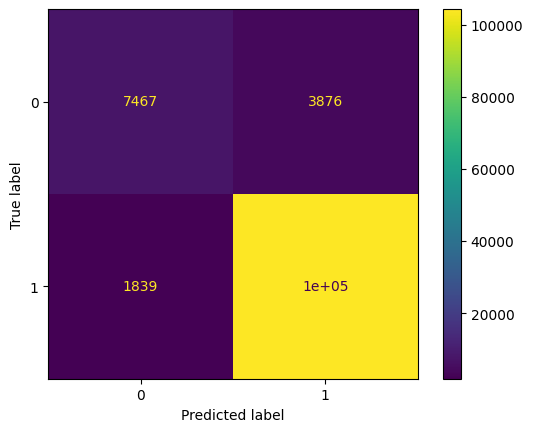

In [7]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [8]:
#Uncomment if you want to find new rules with different support

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='RACE CODE CD',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 7557/7557 [00:00<00:00, 99107.48it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 6703/6703 [00:03<00:00, 2046.26it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 101141/101141 [1:31:21<00:00, 18.45it/s] 


Number of if-thens: 101141


In [16]:

from facts.utils import load_rules_by_if,save_rules_by_if
save_rules_by_if("rulesSSL_atomic.data", rules_by_if)

In [20]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="RACE CODE CD", params=params)

100%|██████████| 6702/6702 [13:36<00:00,  8.21it/s]


In [21]:
save_rules_by_if("rulesSSL_cumulative.data", rules_with_cumulative)

In [11]:
# from facts.predicate import drop_two_above
# ifthens = facts.rulesbyif2rules(rules_by_if)
# age = [val.left for val in X['PREDICTOR RAT AGE AT LATEST ARREST'].unique()]
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
# rules_by_if = facts.rules2rulesbyif(ifthens)

In [8]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesSSL.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [9]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesSSL.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [14]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["WHI"][1][0][1]-e[1]["BLK"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'WHI', 2.21% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with correctness 98.04%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with correctness 0.00%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with correctness 0.00%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with correctness 0.00%.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PRED

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [18]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'PREDICTOR RAT AGE AT LATEST ARREST':10,	'PREDICTOR RAT VICTIM SHOOTING INCIDENTS':1,	
'PREDICTOR RAT VICTIM BATTERY OR ASSAULT':1,	'PREDICTOR RAT ARRESTS VIOLENT OFFENSES':1,	'PREDICTOR RAT GANG AFFILIATION':1,
'PREDICTOR RAT NARCOTIC ARRESTS':1,	'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY':1,	'PREDICTOR RAT UUW ARRESTS':1,	'SEX CODE CD':100,	'RACE CODE CD':100}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 2:
	Protected Subgroup 'M', 3.35% covered out of 302230
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 44.67%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 10.25%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 44.67%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 10.25%.
		Aggregate cost of the above recourses = -0.27
	Protected Subgroup 'F', 3.90% covered out of 96295
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 79.59%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 34.69%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 79.59%.
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1 with correctness 34.69%.
		Aggregate cost of the above recourses = -0.57
	Bias against M. Unfairness measure = 0.3.
If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9:
	Protected Subgroup 'M', 2.34% covered out of 302

## Minimum cost above threshold

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT NARCOTIC ARRESTS = 1:
	Protected Subgroup 'M', 24.66% covered out of 302230
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'F', 16.71% covered out of 96295
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 53.33%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 53.33%.
		Aggregate cost of the above recourses = 1.00
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'M', 20.75% covered out of 302230
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'F', 16.15% covered out of 96295
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 55.17%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 55.17%.
		Aggregate cost of the above recourses = 1.00
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM SHOOTING 

## Mean cost above threshold

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If PREDICTOR RAT NARCOTIC ARRESTS = 1:
	Protected Subgroup 'M', 24.66% covered out of 302230
		No recourses for this subgroup!
	Protected Subgroup 'F', 16.71% covered out of 96295
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 53.33%.
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'M', 20.75% covered out of 302230
		No recourses for this subgroup!
	Protected Subgroup 'F', 16.15% covered out of 96295
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 55.17%.
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'M', 20.18% covered out of 302230
		No recourses for this subgroup!
	Protected Subgroup 'F', 15.83% covered out of 96295
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with correctness 56.28%.
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICT

## Number above threshold

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Protected Subgroup 'M', 2.58% covered out of 302230
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'F', 2.70% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 76.47%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 70.59%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 64.71%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 52.94%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 76.47%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 76.47%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 76.47%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 70.59%.
		Make PREDICTOR RAT TREND

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [18]:
import dill

with open("stateSSL.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Protected Subgroup 'M', 2.58% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 39.36%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 31.38%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 23.94%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 18.09%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 42.02%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 38.30%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 46.28%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 31.38%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 42.02%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE

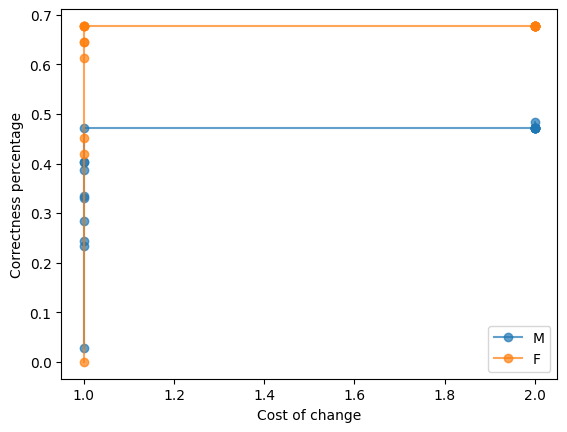

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.62% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 38.98%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 35.59%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 27.12%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 18.64%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 41.53%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 36.44%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 45.76%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 35.59%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 41.53%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE

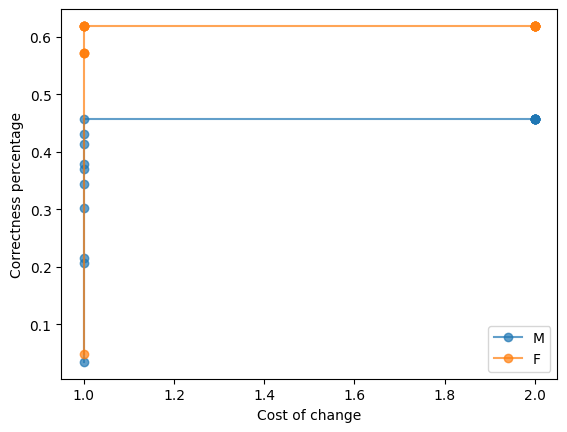

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.37% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 43.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 43.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 41.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 31.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 44.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 43.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 46.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 43.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 44.00%.
		Make PREDICTOR RAT TR

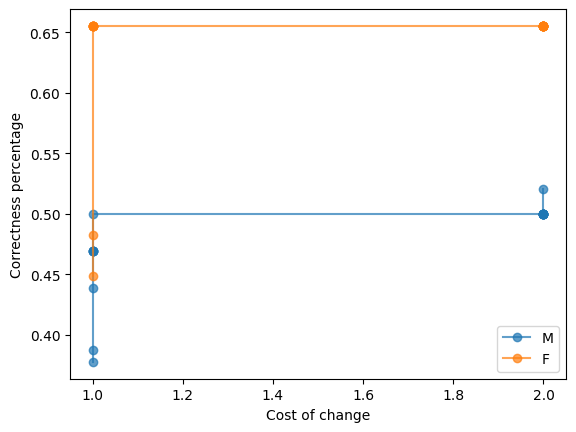

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.7, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.77% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 44.19%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 35.66%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 27.91%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 22.48%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 45.74%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 41.86%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 50.39%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 35.66%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 45.74%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE

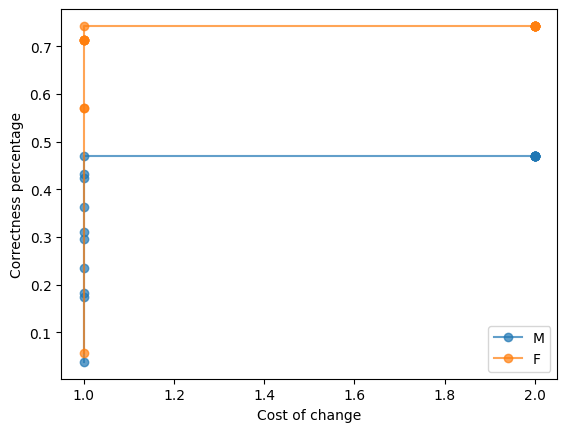

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 2.13% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 45.81%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 36.77%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 28.39%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 21.94%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 49.03%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 44.52%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 53.55%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 36.77%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 49.03%.
		Make PREDICT

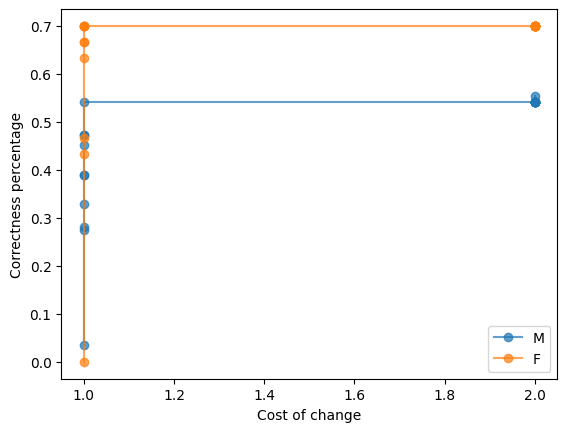

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.42% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 44.66%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 40.78%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 31.07%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 21.36%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 46.60%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 41.75%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 51.46%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 40.78%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 46.60%.
		Make PREDICT

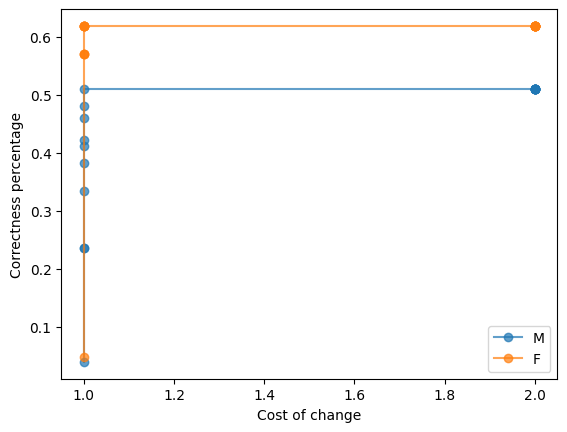

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 2.83% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 25.73%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 25.24%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 24.27%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 25.73%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 25.73%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 25.73%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 25.24%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 25.73%.
		Make RACE CODE CD = WWH 

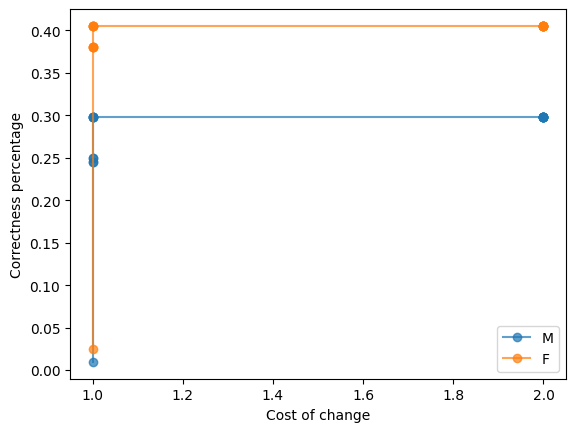

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, PREDICTOR RAT UUW ARRESTS = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 2.06% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 45.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 36.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 26.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 19.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 47.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 44.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 50.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 36.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 47.33%.
		Make PREDICTOR RAT TREND I

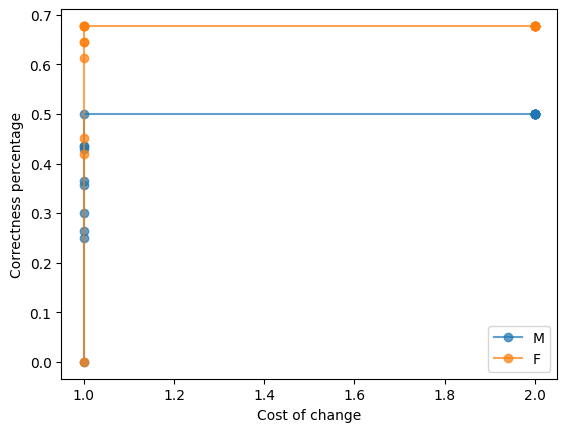

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9, PREDICTOR RAT UUW ARRESTS = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.39% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 36.63%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 32.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 22.77%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 16.83%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 39.60%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 33.66%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 44.55%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 32.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 39.60%.
		Make PREDICTOR RAT TREND I

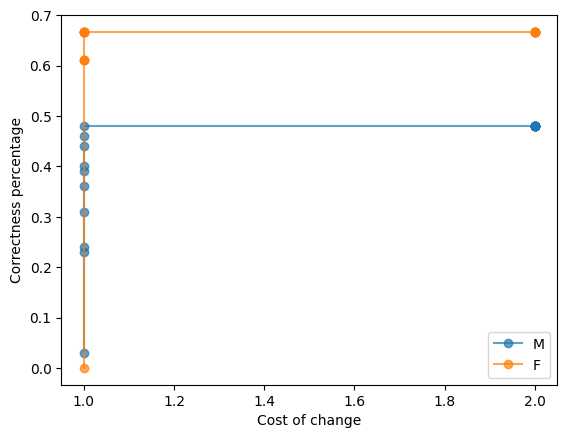

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, RACE CODE CD = BLK:
	Protected Subgroup 'M', 1.35% covered out of 302230
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 46.94%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 42.86%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 32.65%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 22.45%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WWH with correctness 48.98%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WWH with correctness 43.88%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 54.08%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WWH with correctness 42.86%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, RACE CODE CD = WHI with correctness 48.98%.
		Make PREDICT

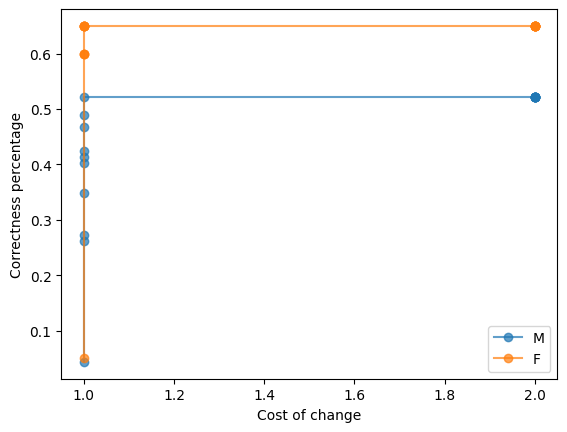

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    # filter_sequence=["remove-below-thr"]
)

cum_cors = facts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="SEX CODE CD")

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [16]:
import dill

with open("stateSSL.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)